In [1]:
import numpy as np 
import math 
from sklearn.metrics import mean_squared_error

### 数据准备部分

In [14]:
def shuffle_data(X,y,seed=None):
    "将X和y的数据进行随机排序/乱序化"
    if seed:
        np.random.seed(seed)
    idx=np.arange(X.shape[0])
    print(type(idx))
    np.random.shuffle(idx)
    return X[idx],y[idx] #对于np.array，idx作为index数组可以改变array的顺序

In [15]:
def train_test_split(X,y,test_size=0.5,shuffle=True,seed=None):
    '将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌'
    if shuffle:
        X,y=shuffle_data(X,y,seed)
    split_i=len(y)-int(len(y)//(1/test_size))
    #split_i=len(y)-int(len(y)*test_size)
    X_train,X_test=X[:split_i],X[split_i:]
    y_train,y_test=y[:split_i],y[split_i:]
    
    return X_train,X_test,y_train,y_test

In [16]:
from sklearn.datasets import make_regression
import matplotlib.pylab as plt

In [17]:
X,y=make_regression(n_samples=100,n_features=1,noise=20)

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

<class 'numpy.ndarray'>


因为使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题，所以对于X进行排序

In [26]:
s=sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))],key=lambda j:j[0])

In [27]:
s

[(-2.777652516411223, -63.86341947854863),
 (-2.4393605237626743, -81.54845980690718),
 (-1.4272894937453167, 0.2503467371642145),
 (-1.4251206924621043, -52.215035509139994),
 (-1.3990066304728683, -58.92671225045021),
 (-1.3289354587644633, -31.61776999822829),
 (-0.9916739834275302, -54.95996364941544),
 (-0.7433926516988061, -33.637429795883705),
 (-0.5566291992559254, -17.514649891105208),
 (-0.5252389068323705, -8.71962622092439),
 (-0.49362480700596745, -12.331797315811652),
 (-0.485939964206811, -23.31824326865616),
 (-0.05569337760819045, 7.440033770223184),
 (0.12145256130655382, 9.196244393726104),
 (0.3693226749639103, 46.367660596661096),
 (0.5704677598621049, 12.055197437483585),
 (0.8924830023639687, 34.598934824723415),
 (0.9165758454215892, 14.698024903042832),
 (1.376867420498199, 45.39815189751524),
 (1.7778482214656204, 39.58238718307592)]

In [28]:
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

In [31]:
#y_test

## 线性回归

In [37]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数
        learning_rate:float 学习率
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
    
    def initialize_weights(self,n_features):
        """初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"""
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
        #Uniform Distribution/Xavier/MSRA/Gaussian
        
    def fit(self,X,y):
        #插入偏置列1到X中
        X=np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_errors=[]#保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        #进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred=X.dot(self.w)#进行预测
            #计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred
    

In [38]:
model=Regression(n_iterations=1000,learning_rate=0.01)

In [39]:
model.fit(X_train,y_train)

Text(0.5, 0, 'Steps')

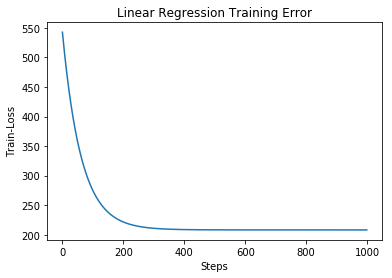

In [41]:
training,=plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")

In [42]:
model.w

array([ 1.76820979, 28.95236682])

### 评价模型

In [43]:
y_pred=model.predict(X_test)

In [44]:
mse=mean_squared_error(y_pred,y_test)

In [45]:
mse

269.1331957102554

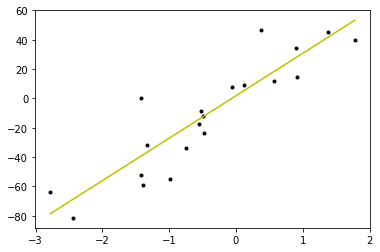

In [47]:
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

### 带有最小二乘法的线性回归

In [53]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [54]:
lsm_function(X_train,y_train)

array([ 1.76645796, 28.96240671])

In [55]:
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    
    learning_rate
    
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)
        

In [56]:
model=LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)

In [57]:
model.fit(X_train,y_train)

In [58]:
model.w

array([ 1.76645796, 28.96240671])

In [59]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差: 269.13175647924027


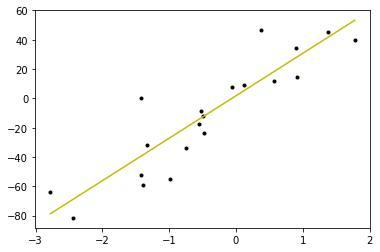

In [60]:
test_and_draw(model)

## 正则化回归

### L1正则化参数

In [71]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [72]:
l1=l1_regularization(alpha=0.01)

In [73]:
l1([-3,4])

0.07

In [75]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

### L2正则化参数

In [76]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

### Lasso线性回归

In [83]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

In [91]:
model=LassoLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [92]:
model.fit(X_train,y_train)

In [93]:
model.w

array([ 1.76645796, 28.96240671])

方差: 269.1317564792403


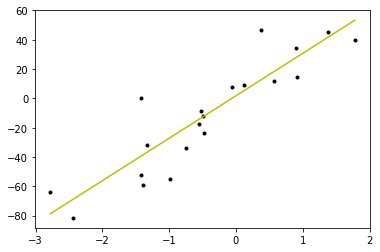

In [87]:
test_and_draw(model)

### Ridge线性回归

In [103]:
class RidgeLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l2_regularization(alpha=alpha)
        super(RidgeLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(RidgeLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(RidgeLinearRegression,self).predict(X)

In [104]:
model=RidgeLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [105]:
model.fit(X_train,y_train)

In [106]:
model.w

array([ 1.76645796, 28.96240671])

方差: 269.1317564792403


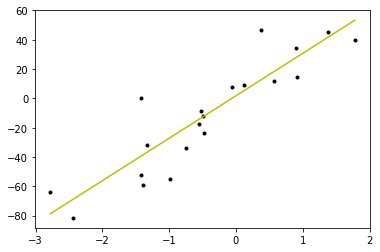

In [107]:
test_and_draw(model)

### L1，L2调和的正则化

在调和的正则化中，

l1_ratio:调和时，L1正则化的值所占的百分比[0,1]

_l2_ratio=1-l1_ratio(事实上在算法中也找不到l2_ratio)

alpha:全局的整体的正则化权重

#### $Loss = mse + \alpha(l1\_ratio * L1Loss + (1-l1\_ratio) * L2Loss)$

In [108]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    
    def __init__(self,alpha,l1_ratio=0.5):
        self.alpha=alpha
        self.l1_ratio=l1_ratio
    
    def __call__(self,w):
        l1_loss=self.l1_ratio*np.linalg.norm(w,ord=1)
        l2_loss=(1-self.l1_ratio)*0.5*w.T.dot(w)#np.linalg.norm(w,ord=2)**2
        return self.alpha*(l1_loss+l2_loss)
    def grad(self,w):
        l1_grad=self.l1_ratio*np.sign(w)
        l2_grad=(1-self.l1_ratio)*w
        return self.alpha*(l1_grad+l2_grad)
        

In [109]:
l1_l2=l1_l2_regularization(alpha=0.1)

In [110]:
l1_l2(np.array([3,4]))

0.9750000000000001

In [111]:
l1_l2.grad(np.array([3,4]))

array([0.2 , 0.25])

In [113]:
0.5*np.sign(np.array([3,4]))

array([0.5, 0.5])

In [114]:
0.5*np.array([3,4])

array([1.5, 2. ])

### ElasticNetLinearRegression

In [117]:
class ElasticNetLinearRegression(Regression):
    """
    ElasticNet线性回归算法
    ----------------------
    alpha:全局正则化参数
    l1_ratio:L1正则化参数比例
    n_iterations
    learning_rate
    """
    def __init__(self,alpha=0.05,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01):
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        super(ElasticNetLinearRegression,self).__init__(n_iterations,learning_rate)
    def fit(self,X,y):
        super(ElasticNetLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(ElasticNetLinearRegression,self).predict(X)

In [118]:
model=ElasticNetLinearRegression(l1_ratio=0.5,alpha=1.2)

In [119]:
model.fit(X_train,y_train)

方差: 269.13175647947133


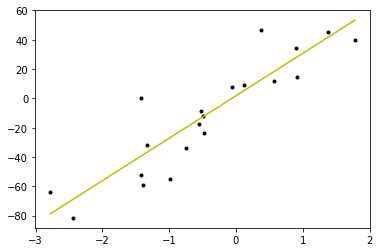

In [120]:
test_and_draw(model)

## 多项式回归

一阶多项式:x,y,z,x2,x3,x4....

二阶多项式:x1^2,x2^2,x3^2,x1x2,x1x3,x2x3

三阶多项式:x1^3,x1x1x2,x1x2x3....

### 构造多项式特征

In [270]:
from itertools import combinations_with_replacement

def polynomial_features(X,degree):
    n_samples,n_features=np.shape(X)
    ##对于每一行的Feature构造排列组合，根据排列组合进行特征的乘积，形成新的X`
    
    def index_combinations():
        combs=[combinations_with_replacement(range(n_features),i) for i in range(0,degree+1)]
        new_combs=[item for sub in combs for item in sub]
        return new_combs
    #print("Feature 列的排列组合:->",[x for x in index_combinations()])
    comb=index_combinations()
    feature_length=len(comb)
    output=np.empty((n_samples,feature_length))
    #print(output.shape)
    for i,index_combs in enumerate(comb):
        output[:,i]=np.prod(X[:, index_combs], axis=1)
    return output 

In [271]:
polynomial_features(np.array([[1,2],[4,5]]),degree=3)

array([[  1.,   1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [165]:
### combinations_with_replacement

In [169]:
for x in combinations_with_replacement([0,1],0):print(x)

()


In [174]:
class PolyRegression(Regression):
    """多项式回归就是将原来的feature转化成多阶的新feature，之后进行线性回归:
    
    ------------------------------------------
    
    degree:最大的阶数
    
    n_iterations:float
    
    learning_rate:float
    
    """
    def __init__(self,degree,n_iterations=3000,learning_rate=0.01):
        
        self.degree=degree
        
        self.regularization=lambda x:0
        
        self.regularization.grad=lambda x:0
        
        super(PolyRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
        
    def fit(self,X,y):
        
        X=polynomial_features(X,degree=self.degree)
        
        super(PolyRegression,self).fit(X,y)
        
    def predict(self,X):
        
        X=polynomial_features(X,degree=self.degree)
        
        return super(PolyRegression,self).predict(X)

In [183]:
model=PolyRegression(degree=5)

In [184]:
model.fit(X_train,y_train)

Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0, 0)]
(80, 6)


Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0, 0)]
(20, 6)
方差: 460.77098778997527


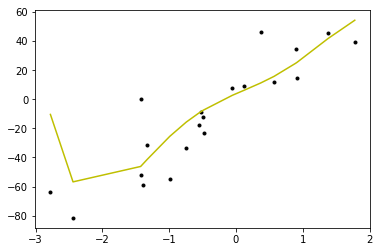

In [185]:
test_and_draw(model)

### 数据的Normalize变换(归一化操作)

行归一化

In [194]:
def normalize(X,axis=-1,order=2):
    "将数据集的每一行进行列的归一化--每一行的向量的L2范数归一"
    L2=np.linalg.norm(X,order,axis)
    L2[L2==0]=1#为了滤掉为0的L2距离，在归一化的时候会出现除零问题
    return X/np.expand_dims(L2,axis)

In [195]:
normalize([[1,2],[3,4]],order=2,axis=-1)

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [198]:
class LassoRegression(Regression):
    """带有L1范数的Lasso多项式回归
    ---------------------------
    degree:多项式的最高阶
    
    alpha:L1的系数
    
    n_iteration:float
    
    learning_rate:int
    
    normailzed:bool
    
    """
    
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_regularization(alpha=alpha)
        self.normalized=normalized
        super(LassoRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(LassoRegression,self).fit(X,y)
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(LassoRegression,self).predict(X)

In [218]:
model=LassoRegression(degree=5,alpha=1000,n_iterations=2000,learning_rate=0.1)

In [219]:
model.fit(X_train,y_train)

Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0, 0)]
(80, 6)


In [220]:
model.w

array([ -2.35512636,   8.62687535,  29.29644466, -17.86443356,
       -24.78060442,  12.30679766,  67.06180973])

Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0, 0)]
(20, 6)
方差: 280.3909676219628


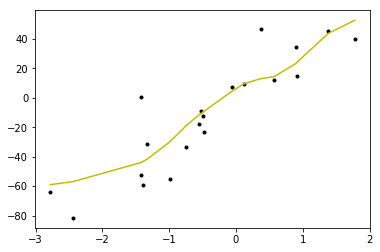

In [221]:
test_and_draw(model)

### 带有多项式的Ridge 回归

In [235]:
class RidgeRegression(Regression):
    """带有多项式和归一化的Ridge回归
    -----------------------------
    degree:最大阶数
    alpha:正则化系数
    n_iterations:步数
    learning_rate:步长
    normalized
    """
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normailzed=True):
        self.degree=degree
        self.regularization=l2_regularization(alpha=alpha)
        self.normalized=normailzed
        super(RidgeRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(RidgeRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(RidgeRegression,self).predict(X)
    

In [236]:
model=RidgeRegression(degree=3,alpha=100,n_iterations=1000,learning_rate=1)

In [237]:
model.fit(X_train,y_train)

Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0)]
(80, 4)


In [238]:
#model.normalized

In [239]:
def test_and_draw2(model):
    y_pred=model.predict(X_test)
    print(y_pred)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0)]
(20, 4)
[-52.49802522 -52.08217519 -45.40447721 -45.36676225 -44.89673496
 -43.47880232 -32.41844679 -19.37556709  -8.97843431  -7.39855678
  -5.88678031  -5.53231985   5.30039917   6.33997925   8.79050984
  13.83826359  26.7832637   27.79740523  42.93566464  49.82890323]
方差: 319.0960887831242


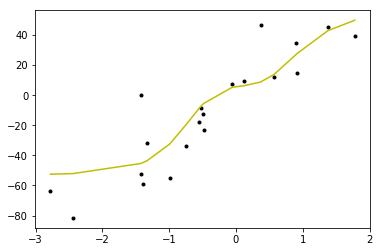

In [240]:
test_and_draw2(model)

In [245]:
class ElasticNetRegression(Regression):
    """
    带有L1L2调和的线性回归
    
    -----------------
    degree
    
    alpha
    
    l1_ratio
    
    n_iterations
    
    learning_rate
    
    normalized
    """
    def __init__(self,degree,alpha=0.5,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        self.normalized=normalized
        super(ElasticNetRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(ElasticNetRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(ElasticNetRegression,self).predict(X)
    

In [255]:
model=ElasticNetRegression(degree=4,alpha=2000,l1_ratio=0.8,n_iterations=1000,learning_rate=0.01)

In [256]:
model.fit(X_train,y_train)

Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0)]
(80, 5)


Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0)]
(20, 5)
方差: 649.4717468844752


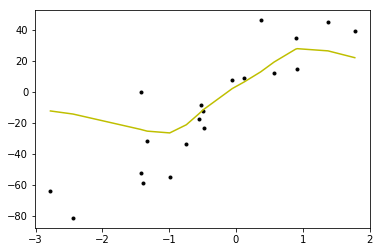

In [257]:
test_and_draw(model)

## 读入真实的数据

In [258]:
import pandas as pd 

/Users/deepglint/miniconda2/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [260]:
train=pd.read_csv('./data/train_1.csv')

In [263]:
y=np.asarray(train['SalePrice'])

In [264]:
train1=train.drop(['Id','SalePrice'],axis=1)

In [265]:
X=np.asarray(pd.get_dummies(train1).reset_index(drop=True))

In [266]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

<class 'numpy.ndarray'>


In [300]:
model=ElasticNetRegression(degree=1,alpha=1000,l1_ratio=0.5,n_iterations=80000,learning_rate=0.001)

In [312]:
model.fit(X_train,y_train)

In [302]:
pred=model.predict(X_test)

In [303]:
logrmse=np.sqrt(mean_squared_error(np.log(abs(y_test)),np.log(abs(pred))))

In [304]:
logrmse

0.36038501662814537

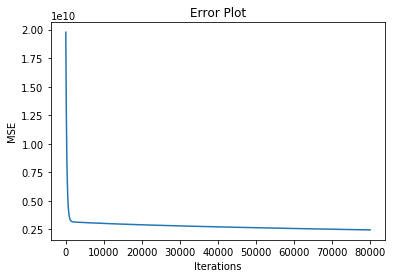

In [305]:
n=len(model.training_errors)
training=plt.plot(range(n),model.training_errors,label="Training Error")
#plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.show()

In [306]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [311]:
def benchmark(model,testset,label):
    pred=model.predict(testset)
    print(pred)
    if pred[pred<0].shape[0]>0:
        print("Neg Value")
        return -1
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(abs(pred))))
    print("RMSE:",rmse)
    print("LRMSE:",lrmse)
    return lrmse

In [308]:
def train_test():
    model=make_pipeline(RobustScaler(),ElasticNetRegression(degree=1,alpha=1000,l1_ratio=0.5,n_iterations=80000,learning_rate=0.001))
    model.fit(X_train,y_train)
    lrmse=benchmark(model,X_test,y_test)
    

In [309]:
train_test()

[155697.30075533 171404.40302134 117785.99385461 120079.62323039
 152453.87583249 118628.20056575 107347.45571122 152974.69620733
 191220.04000648 172365.94459564 131365.51428616 144732.31842538
 184230.83987507 109096.68479109 183184.82626866 223725.41490536
 280363.15588922 153569.08490955 143913.44029696 127703.25076787
 209574.37381697 187451.8850328  160094.36733431 110559.71207879
 261596.34059617  97276.47016152 303889.75688662 118620.4102683
 171382.92068565 110185.1654419  154584.54095715 154340.20995287
 193984.92201809 206342.14452684 137033.76596012 157332.33534967
 147781.48179258 143114.18391995 151287.69986877 270424.30881518
 178937.29859366 156168.30037589 292843.96723478 157116.89554019
 216169.13481731 231675.8721586  151254.0360897  168945.84877464
 150861.5746712  147989.50175559 165456.76294319 171735.76045344
 171974.21853124 119249.05183723 199595.11265914 215833.66615194
 162350.85785938 173304.86986122 141471.66167389 202157.59275927
 210236.39381224 171829.17

作业：

大家使用我们自己的模型，回归房价数据，并得到最优解